# Importing libs and Loading datasets

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
!pip install lifelines

     |████████████████████████████████| 348kB 7.7MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-cp36-none-any.whl size=4035 sha256=397a3bfc8ac518f645b0c013e165d39533c98b063040e8f8c9bf8b915551f544
  Stored in directory: /root/.cache/pip/wheels/dc/68/dc/91321c55fba449755524481854f5be70d41912b8f886f908bb
Successfully built autograd-gamma


In [ ]:
!pip install shap

     |████████████████████████████████| 358kB 9.0MB/s 
  Created wheel for shap: filename=shap-0.38.1-cp36-cp36m-linux_x86_64.whl size=489395 sha256=491b2a1a1a69b696b0c8a8f7b0cd1ba3eb610f28d6669fd39b7bbcd650a38582
  Stored in directory: /root/.cache/pip/wheels/a8/fb/e4/88012be41842b9be62ae18d82d1b1e880daf8539d1fef1fa00
Successfully built shap


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold

from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn import svm
import xgboost as xgb

from sklearn.metrics import roc_curve, precision_recall_curve, auc,mean_squared_error, r2_score, classification_report, confusion_matrix
from scipy.stats.stats import pearsonr

import shap

from lifelines import KaplanMeierFitter

In [ ]:
root_path = "/gdrive/My Drive"
columns = ["asset_id","runtime","setting1","setting2","setting3"]

if len(columns) == 5:
  for i in range(1,22):
    columns.append(f"tag{i}")

df = pd.read_table(f"{root_path}/PM_train.txt", delimiter=" ", sep = "\t", header=None)

df = df.iloc[:,:len(columns)]
df.columns=columns

df_test =  pd.read_table(f"{root_path}/PM_test.txt", delimiter=" ", sep = "\t", header=None)
df_test = df_test.iloc[:,:len(columns)]
df_test.columns=columns

# Functions

In [ ]:
def get_time(row,df_tr):
  '''Get the Remaining Time based in the actual Runtime and the Maximum Runtime 
  for each asset'''
  id = row['asset_id']
  day = row['runtime']
  max_days = df_tr.loc[id]
  rem_day = max_days - day
  return rem_day

In [ ]:
def simulate_scenarios(df, test_list, y_pred):
  '''Simulate scenarios with Classification Metrics based in the Business Rules
  '''
  df_sim = df.copy()
  df_sim['target'] = df_sim['runtime'].apply(lambda x: 1 if x <= 20 else 0)

  y_true = df_sim[df_sim['asset_id'].isin(test_list)]['time_rem'].apply(lambda x: 1 if x <= 20 else 0)
  print("Size y_true: ", len(y_true))
  if type(y_pred) != type(pd.DataFrame()):
    y_pred = pd.Series(y_pred)
    y_pred = y_pred.apply(lambda x: 1 if x <= 20 else 0)
  else:
    y_pred = y_pred.apply(lambda x: 1 if x <= 20 else 0)

  print("Size y_pred: ", len(y_pred))
  print(classification_report(y_true, y_pred))
  print("Confusion Matrix")
  print(confusion_matrix(y_true, y_pred))

In [ ]:
#train, test sep
def preproc(df, test_list=[2,13,20,30,31,59,73,90,95,100], deep=False, debug=True): 
  ''' Pre process function for timeseries RUL models.
  It takes the raw dataset and a list of assets for test and:
  - Separates X,y for Train and Test
  - remove low var variables
  - scale variables
   '''

  X_train = df[~df['asset_id'].isin(test_list)].drop(columns=['asset_id'])
  X_test = df[df['asset_id'].isin(test_list)].drop(columns=['asset_id'])

  y_train = y[~y['asset_id'].isin(test_list)]['time_rem']
  y_test = y[y['asset_id'].isin(test_list)]['time_rem']

  #feature selection - remove low var variables
  cols = list(X_train.columns)
  std = X_train.std()

  relevant_features = std[std > 0.000001]

  features = [x for x in list(relevant_features.index) if x not in ['tag6','tag9','tag14','setting1','setting2']]

  if debug:
    print("Features after remove non-var features")
    print(relevant_features)
    print(features)
    print("Features before selection: ", len(list(X_train.columns)))
    print("Features after selection ", len(features))

  X_train = X_train[features]
  X_test = X_test[features]

  #scaling
  if deep:
    scaler = MinMaxScaler()
    X_train[features] = scaler.fit_transform(X_train[features])
    X_test[features] = scaler.transform(X_test[features])

  else:
    scaler = StandardScaler()
    X_train[features] = scaler.fit_transform(X_train[features])
    X_test[features] = scaler.transform(X_test[features])

  return X_train,y_train,X_test,y_test,features,scaler

In [ ]:
def time_series_fold(n,df,model,deep=False):
  '''Creates a Timeseries RUL cross validation k-folds method'''
  rmse_list_t = []
  mae_list_t = []

  rmse_list = []
  mae_list = []

  possible_list = [x for x in range(1,100)]

  for i in range(0,n-1):
    test_list = []
    for i in range(1,n+1):
      if len(possible_list) > 1:
        val = possible_list[random.randint(0, len(possible_list)-1)]
      elif len(possible_list) == 1:
        val = possible_list[0]

      test_list.append(val)
      possible_list.remove(val)
      
    X_train,y_train,X_test,y_test,features = preproc(df, test_list=test_list, deep=deep, debug=False)

    if deep:

        early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

        EPOCHS = 1000

        history = model.fit(
          X_train, y_train,
          epochs=EPOCHS, validation_split = 0.2, verbose=0,
          callbacks=[early_stop])
    else:
      model.fit(X_train,y_train)

    metrics = evaluate(X_train, X_test, y_train, y_test, model, debug=False)

    rmse_list_t.append(metrics['train_rmse'])
    mae_list_t.append(metrics['train_mae'])

    rmse_list.append(metrics['test_rmse'])
    mae_list.append(metrics['test_mae'])

  print(f"Cross Validation {n} folds")
  print("----------Train-----------")
  print("RMSE Mean: ", np.mean(rmse_list_t), "+- ", np.std(rmse_list_t) )
  print("MAE Mean: ", np.mean(mae_list_t), "+- ", np.std(mae_list_t) )

  print("----------Test-----------")
  print("RMSE Mean: ", np.mean(rmse_list), "+- ", np.std(rmse_list) )
  print("MAE Mean: ", np.mean(mae_list), "+- ", np.std(mae_list) )

In [ ]:
#model evaluation

def mean_absolute_percentage_error(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_error(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs(y_true - y_pred))

def evaluate(X_train, X_test, y_train, y_test, model, debug = True, deep=False):
  '''Function that evaluate ML models with regression metrics '''

  y_true = y_train
  if deep:
    y_pred = model.predict(X_train).flatten()
  else:
    y_pred = model.predict(X_train)

  mae_t = mean_absolute_error(y_true, y_pred)
  mape = mean_absolute_percentage_error(y_true, y_pred)
  rmse_t = np.sqrt(mean_squared_error(y_true, y_pred))
  try:
    corr = pearsonr(y_true,y_pred)[0]
  except:
    corr = 0
  if debug:
    print('--------Train-------')
    print("r squared: " + format(r2_score(y_true, y_pred), '.2f'))
    print("MAE: " + format(mae_t, '.3f'))
    print("MAPE: " + format(mape, '.3f'))
    print("RMSE: %f" % (rmse_t))
    print("Correlation: " + format(corr, '.2f'))
  
  
  y_true = y_test
  if deep:
    y_pred = model.predict(X_test).flatten()
  else:
    y_pred = model.predict(X_test)
    
  mae_e = mean_absolute_error(y_true, y_pred)
  mape = mean_absolute_percentage_error(y_true, y_pred)
  rmse_e = np.sqrt(mean_squared_error(y_true, y_pred))
  try:
    corr = pearsonr(y_true,y_pred)[0]
  except:
    corr = 0

  if debug:
    print('--------Test-------')
    print("r squared: " + format(r2_score(y_true, y_pred), '.2f'))
    print("MAE: " + format(mae_e, '.3f'))
    print("MAPE: " + format(mape, '.3f'))
    print("RMSE: %f" % (rmse_e))
    print("Correlation: " + format(corr, '.2f'))

  return {'train_rmse': rmse_t, 'test_rmse': rmse_e , 
          'train_mae': mae_t, 'test_mae': mae_e
          }

def evaluate_graphs(df,X_train, X_test, y_train, y_test, model, features, deep=False):
  '''Function that plots evaluation graphs for RUL models '''
  y_true = y_train
  if deep:
    y_pred = model.predict(X_train).flatten()
  else:
    y_pred = model.predict(X_train)
  
  print('Train fit ')
  #y_pred = xg_reg.predict(df[df['asset_id'] == val].drop(columns=['asset_id']))
  plt.figure(figsize=(30, 8))
  plt.plot(X_train.reset_index().iloc[:,0],y_train, 'c--', linewidth=3)
  plt.plot(X_train.reset_index().iloc[:,0],y_pred, color='orange')
  plt.show()
  print(" ")

  print('Test fit ')
  #Test
  y_true = y_test
  if deep:
    y_pred = model.predict(X_test).flatten()
  else:
    y_pred = model.predict(X_test)

  for val in test_list:
    print(f"Asset {val}")
    print(" ")
    indexes = list(df[df['asset_id'] == val].index)

    #y_pred = model.predict(df[df['asset_id'] == val][features])
    y_pred = model.predict(X_test[X_test.index.isin(indexes)])

    df_eval = df[df['asset_id'] == val]
    #plt.bar(df_eval['runtime'],y[y['asset_id'] == val]['time_rem'])
    plt.plot(df_eval['runtime'],y[y['asset_id'] == val]['time_rem'], 'c--', linewidth=3)
    plt.plot(df_eval['runtime'],y_pred, color='orange')
    plt.show()

# Estatistical Data Analysis

In [ ]:
df.head()

asset_id  runtime  setting1  setting2  ...  tag18  tag19  tag20    tag21
0         1        1   -0.0007   -0.0004  ...   2388  100.0  39.06  23.4190
1         1        2    0.0019   -0.0003  ...   2388  100.0  39.00  23.4236
2         1        3   -0.0043    0.0003  ...   2388  100.0  38.95  23.3442
3         1        4    0.0007    0.0000  ...   2388  100.0  38.88  23.3739
4         1        5   -0.0019   -0.0002  ...   2388  100.0  38.90  23.4044

[5 rows x 26 columns]

In [ ]:
df.describe()

asset_id       runtime  ...         tag20         tag21
count  20631.000000  20631.000000  ...  20631.000000  20631.000000
mean      51.506568    108.807862  ...     38.816271     23.289705
std       29.227633     68.880990  ...      0.180746      0.108251
min        1.000000      1.000000  ...     38.140000     22.894200
25%       26.000000     52.000000  ...     38.700000     23.221800
50%       52.000000    104.000000  ...     38.830000     23.297900
75%       77.000000    156.000000  ...     38.950000     23.366800
max      100.000000    362.000000  ...     39.430000     23.618400

[8 rows x 26 columns]

In [ ]:
# stats for failure
df_tr = df[['asset_id','runtime']].groupby('asset_id').runtime.max()
df_tr.describe()

count    100.000000
mean     206.310000
std       46.342749
min      128.000000
25%      177.000000
50%      199.000000
75%      229.250000
max      362.000000
Name: runtime, dtype: float64

Attempting to set identical left == right == 100.0 results in singular transformations; automatically expanding.
Attempting to set identical left == right == 518.67 results in singular transformations; automatically expanding.
Attempting to set identical left == right == 14.62 results in singular transformations; automatically expanding.
Attempting to set identical left == right == 1.3 results in singular transformations; automatically expanding.
Attempting to set identical left == right == 0.03 results in singular transformations; automatically expanding.
Attempting to set identical left == right == 2388.0 results in singular transformations; automatically expanding.
Attempting to set identical bottom == top == 100.0 results in singular transformations; automatically expanding.
Attempting to set identical left == right == 100.0 results in singular transformations; automatically expanding.
Attempting to set identical bottom == top == 518.67 results in singular transformations; automati

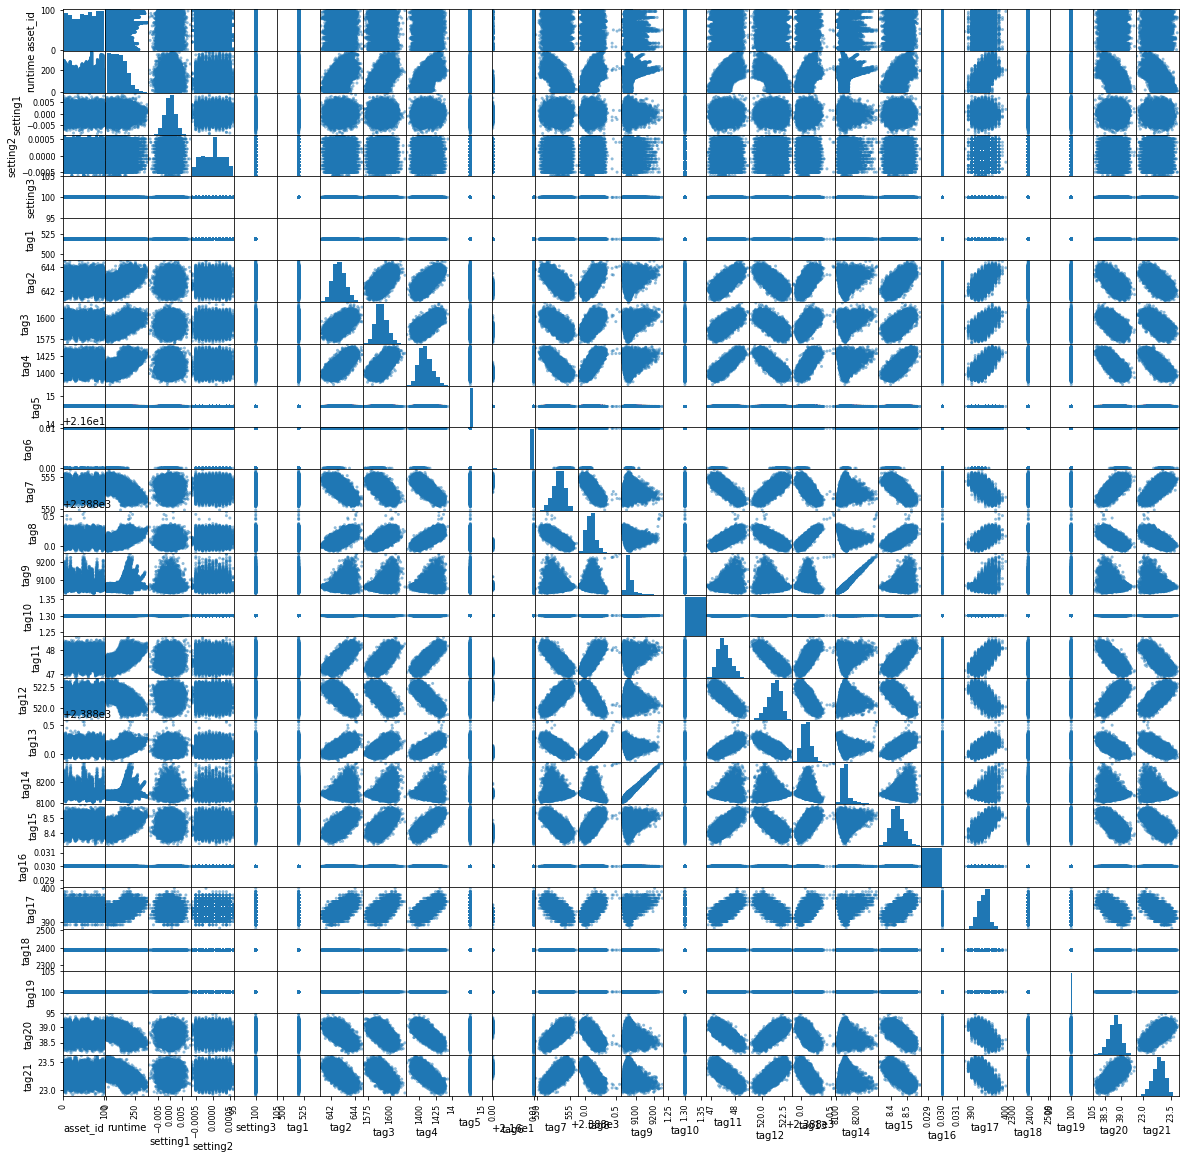

In [ ]:
pd.plotting.scatter_matrix(df, figsize=(20, 20))
plt.show()

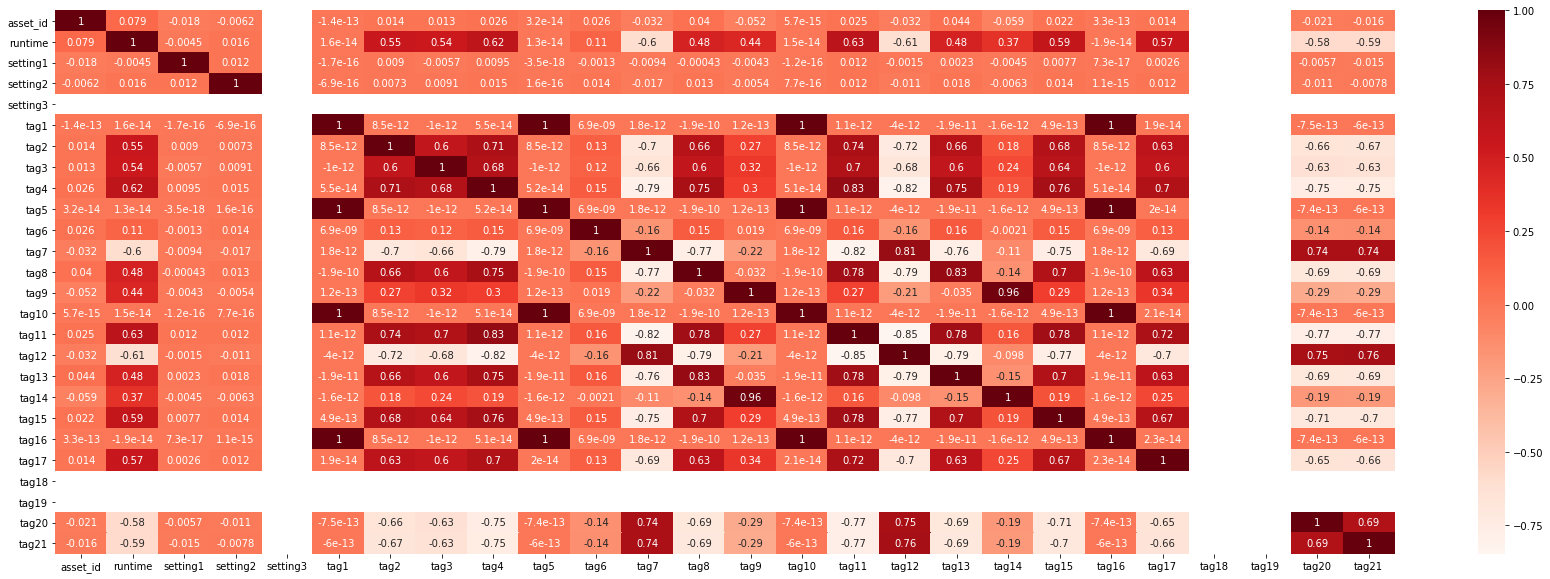

In [ ]:
cor = df.corr()
plt.figure(figsize=(30, 10))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
#time remaning calc - creating the target
df_tr = df[['asset_id','runtime']].groupby('asset_id').runtime.max()

y = df[['asset_id','runtime']]
y['time_rem'] = df[['asset_id','runtime']].apply(lambda row: get_time(row, df_tr), axis=1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
#list for testing
test_list=[2,13,20,30,31,59,73,90,95,100]

SETTING1
 


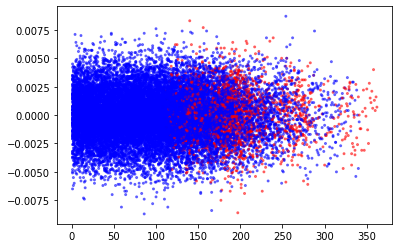

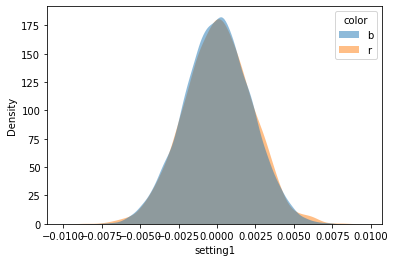

SETTING2
 


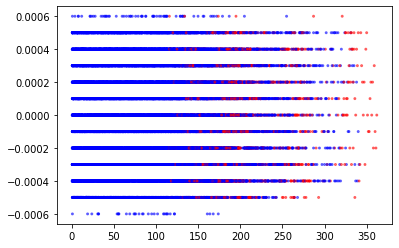

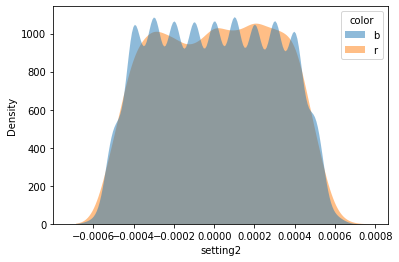

SETTING3
 


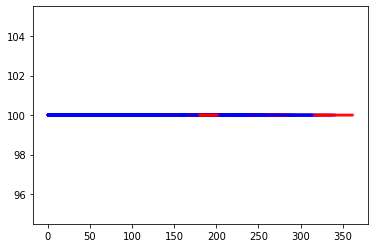

Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.


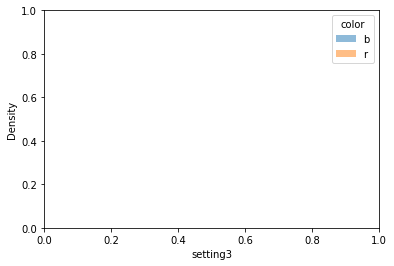

TAG1
 


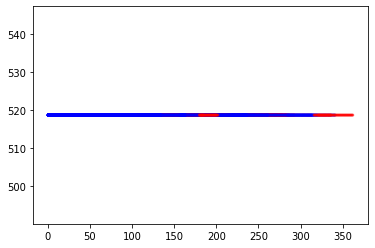

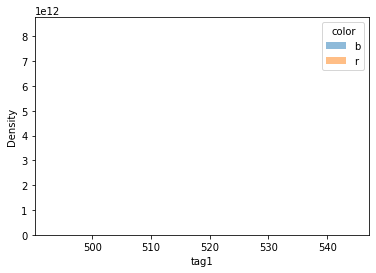

TAG2
 


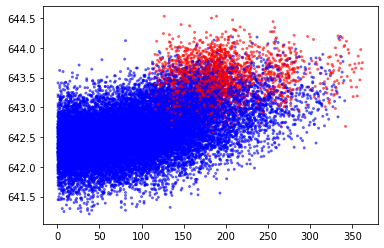

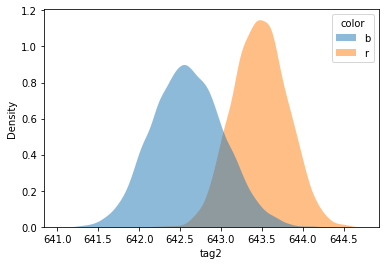

TAG3
 


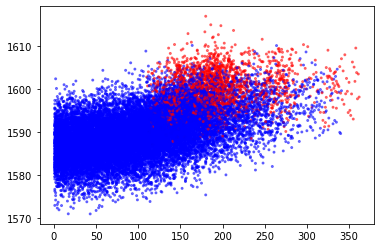

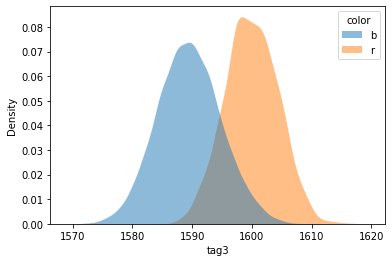

TAG4
 


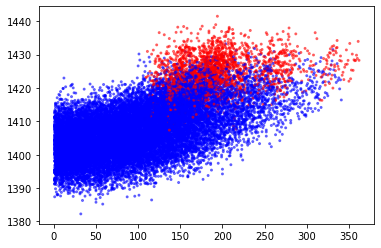

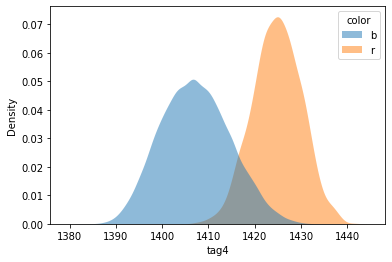

TAG5
 


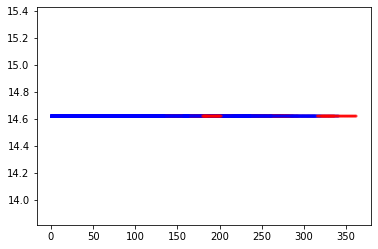

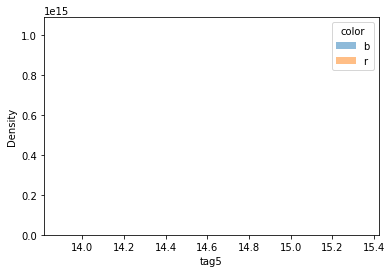

TAG6
 


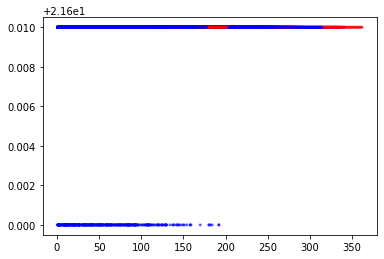

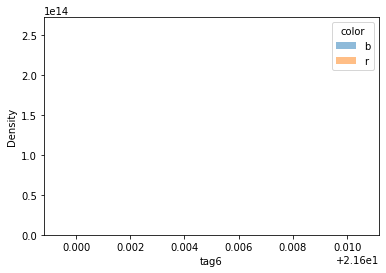

TAG7
 


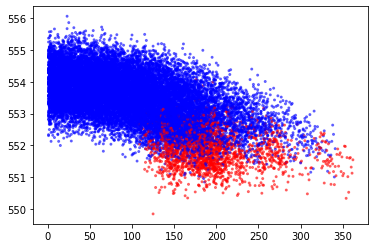

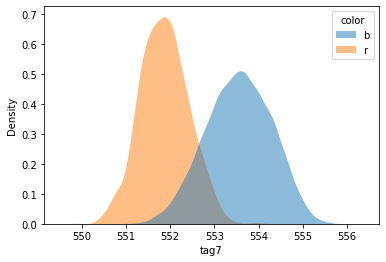

TAG8
 


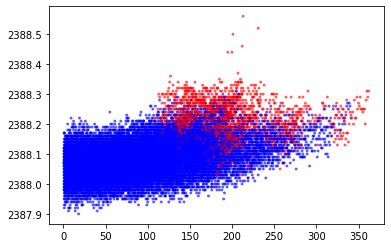

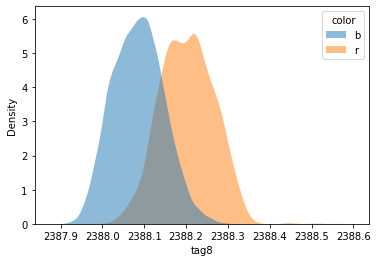

TAG9
 


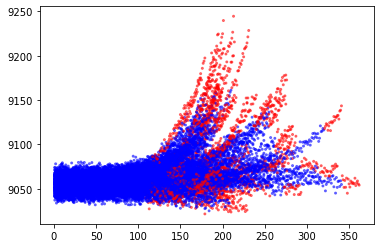

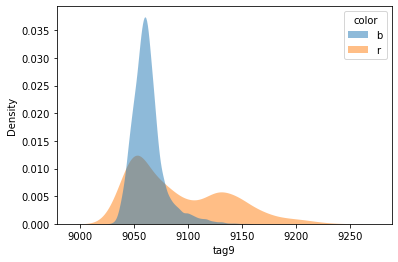

TAG10
 


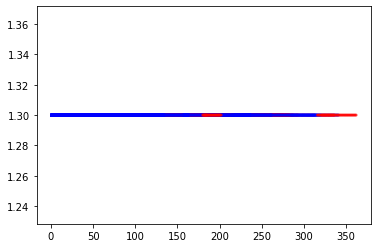

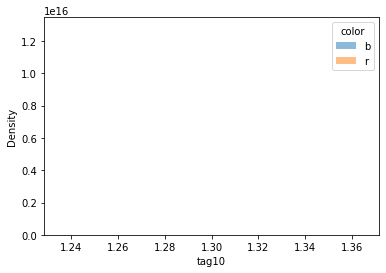

TAG11
 


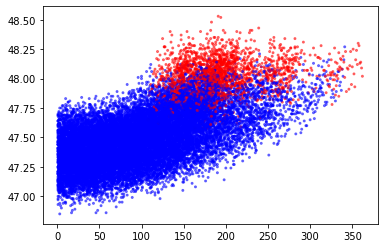

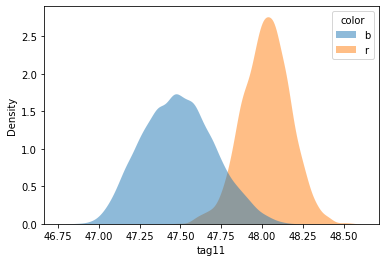

TAG12
 


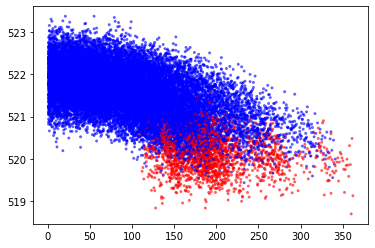

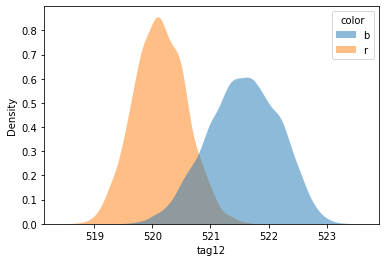

TAG13
 


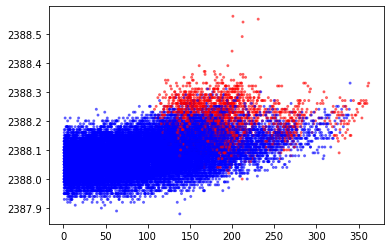

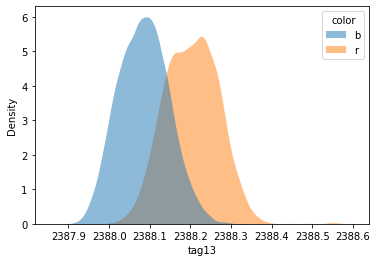

TAG14
 


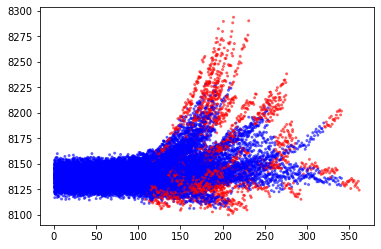

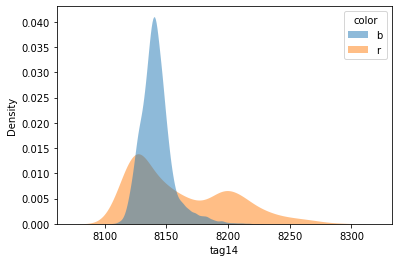

TAG15
 


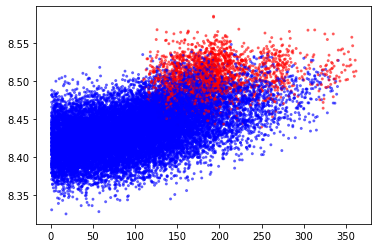

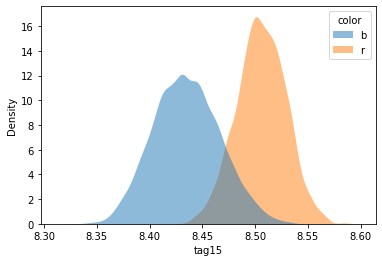

TAG16
 


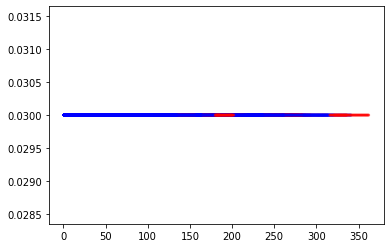

TAG17
 


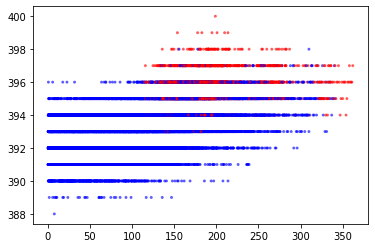

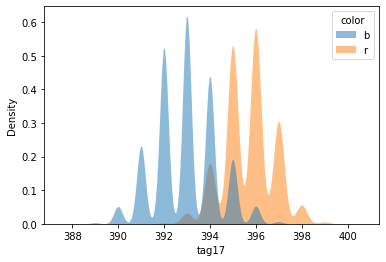

TAG18
 


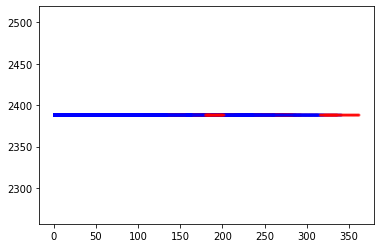

Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.


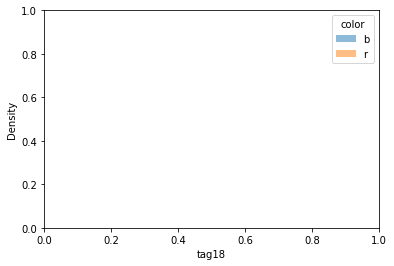

TAG19
 


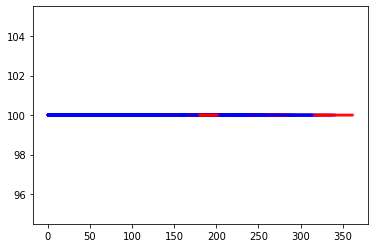

Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.


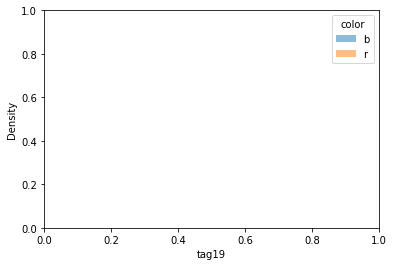

TAG20
 


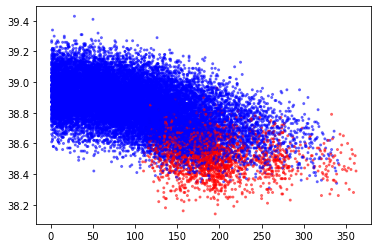

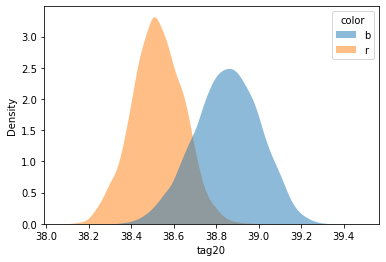

TAG21
 


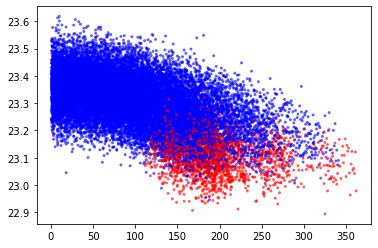

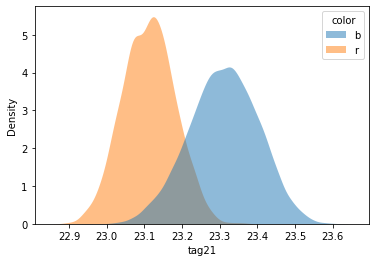

In [ ]:
df_anali = df.copy()
df_anali['time_rem'] = y['time_rem']
df_anali['color'] = df_anali['time_rem'].apply(lambda x: 'r' if x <= 20 else 'b')

col_list = [ x for x in list(df_anali.columns) if x not in ['asset_id','color','runtime','time_rem']]

for c in col_list:
  print(c.upper())
  print(" ")
  temp = df_anali[['runtime',c,'color']]
  #sns.scatterplot(data=temp, x="runtime", y=c, hue="color")
  plt.scatter(temp['runtime'] , temp[c] , c= temp['color'], alpha=0.5, s=4)
  plt.show()
  try:
    sns.kdeplot(data=temp, x=c, hue="color",fill=True, common_norm=False,alpha=.5, linewidth=0)
    plt.show()
  except:
    pass


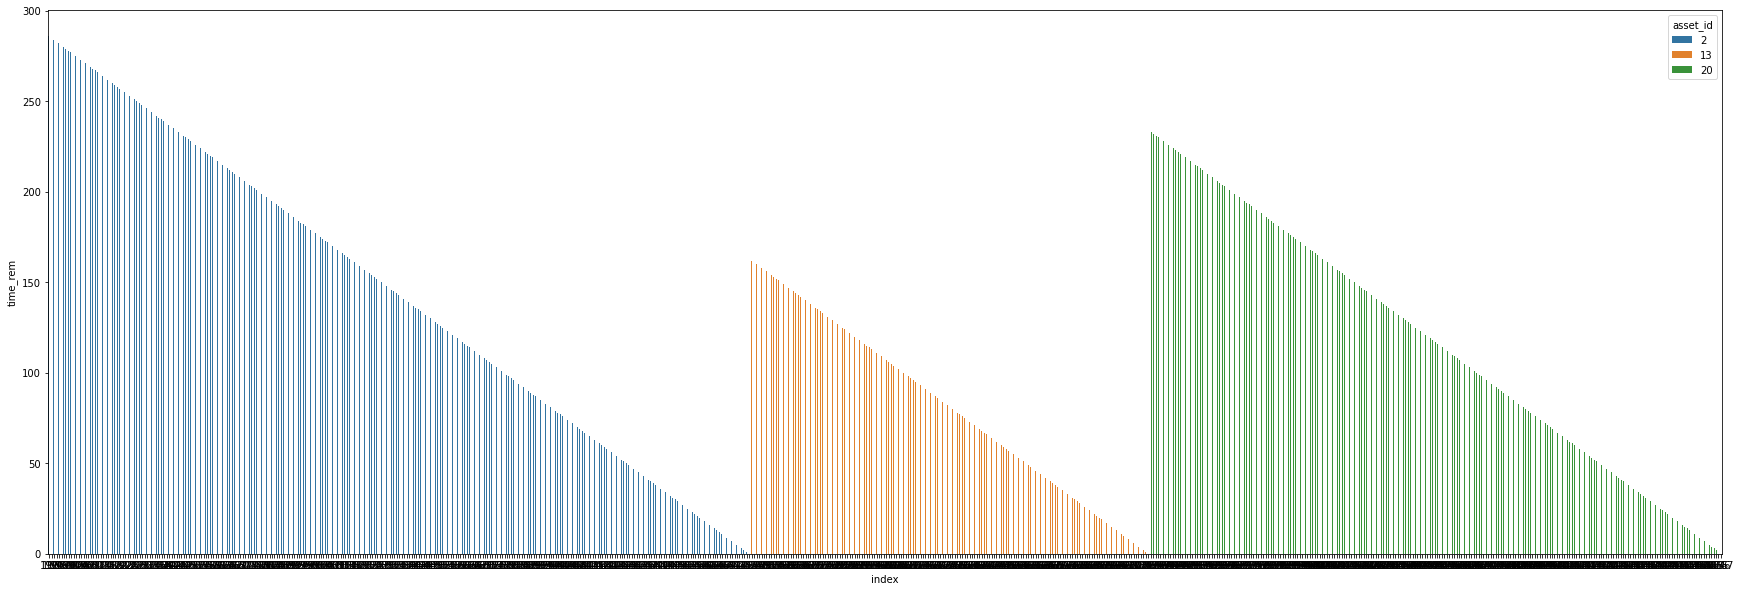

In [ ]:
test_list=[2,13,20]
plt.figure(figsize=(30, 10))
sns.barplot(data=y[y['asset_id'].isin(test_list)].reset_index(), x="index", y="time_rem", hue="asset_id")

# Kaplan Meier - Baseline RUL 

In [ ]:
df_train = df[['asset_id','runtime']].groupby('asset_id').runtime.max().reset_index()

In [ ]:
kmf = KaplanMeierFitter()
T = df['runtime']
kmf.fit(T)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 20631 total observations, 0 right-censored observations>

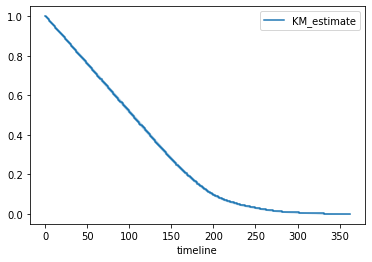

In [ ]:
#chance to be alive
kmf.plot()

In [ ]:
median_survival = kmf.median_survival_time_
maint = median_survival - 20
print(f'Median survival time is : {median_survival} cycles')
print(f'Baseline for a fixed value that Maintenance can use: {maint} cycles')

Median survival time is : 104.0 cycles
Baseline for a fixed value that Maintenance can use: 84.0 cycles


In [ ]:
kmf.survival_function_
kmf.confidence_interval_

KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.0                  1.000000                1.000000
1.0                  0.994107                0.996014
2.0                  0.988873                0.991555
3.0                  0.983731                0.987004
4.0                  0.978637                0.982406
...                       ...                     ...
358.0                0.000069                0.000489
359.0                0.000043                0.000421
360.0                0.000022                0.000351
361.0                0.000006                0.000287
362.0                0.000000                0.000000

[363 rows x 2 columns]

In [ ]:
conditional_time = kmf.conditional_time_to_event_

In [ ]:
df_test_kmf = df_test[['asset_id','runtime']].groupby('asset_id').runtime.max().reset_index()

kmf.survival_function_at_times(df_test_kmf['runtime'])

31     0.849741
49     0.762493
126    0.389269
106    0.486210
98     0.524987
         ...   
97     0.529834
134    0.350783
121    0.413504
97     0.529834
198    0.101934
Name: KM_estimate, Length: 100, dtype: float64

In [ ]:
df_test_baseline = df_test[['asset_id','runtime']]
df_test_baseline['predictions'] = df_test_baseline['runtime'].apply(lambda x: conditional_time.loc[x])
df_test_baseline


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


asset_id  runtime  predictions
0             1        1        103.0
1             1        2        103.0
2             1        3        102.0
3             1        4        102.0
4             1        5        101.0
...         ...      ...          ...
13091       100      194         31.0
13092       100      195         31.0
13093       100      196         31.0
13094       100      197         31.0
13095       100      198         31.0

[13096 rows x 3 columns]

In [ ]:
#simulate for a fixed time - RUL baseline
test_list=[2,13,20,30,31,59,73,90,95,100]

y_true = y[y['asset_id'].isin(test_list)]['time_rem'].apply(lambda x: 1 if x <= 20 else 0)
y_pred = y[y['asset_id'].isin(test_list)]['runtime'].apply(lambda x: 1 if x >= maint else 0)

print(classification_report(y_true, y_pred))
print("Confusion Matrix")
print(confusion_matrix(y_true, y_pred)) 

              precision    recall  f1-score   support

           0       1.00      0.42      0.59      1983
           1       0.15      1.00      0.27       210

    accuracy                           0.47      2193
   macro avg       0.58      0.71      0.43      2193
weighted avg       0.92      0.47      0.56      2193

Confusion Matrix
[[ 830 1153]
 [   0  210]]


## RUL Model Predict


In [ ]:
test_list=[2,13,20,30,31,59,73,90,95,100]

X_train = df[~df['asset_id'].isin(test_list)]
X_test = df[df['asset_id'].isin(test_list)]

y_train = y[~y['asset_id'].isin(test_list)]['time_rem']
y_test = y[y['asset_id'].isin(test_list)]['time_rem']


103.0


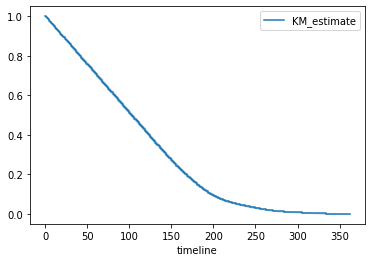

In [ ]:
T = X_train['runtime']
kmf.fit(T)
kmf.plot()
median_survival = kmf.median_survival_time_
print(median_survival)

In [ ]:
#evaluate
def mean_absolute_error(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs(y_true - y_pred))
#train
conditional_time = kmf.conditional_time_to_event_
df_train_baseline = X_train[['asset_id','runtime']]
df_train_baseline['predictions'] = df_train_baseline['runtime'].apply(lambda x: conditional_time.loc[x])

print("------Train------")
rmse = np.sqrt(mean_squared_error(y_train, df_train_baseline['predictions']))
mae = mean_absolute_error(y_train, df_train_baseline['predictions'])
corr = pearsonr(y_train, df_train_baseline['predictions'])[0]
print("RMSE: %f" % (rmse))
print("MAE: %f" % (mae))
print(f"Correlation: {corr}")


#test
conditional_time = kmf.conditional_time_to_event_
df_test_baseline = X_test[['asset_id','runtime']]
df_test_baseline['predictions'] = df_test_baseline['runtime'].apply(lambda x: conditional_time.loc[x])

print("------Test------")
rmse = np.sqrt(mean_squared_error(y_test, df_test_baseline['predictions']))
mae = mean_absolute_error(y_test, df_test_baseline['predictions'])
corr = pearsonr(y_test, df_test_baseline['predictions'])[0]
print("RMSE: %f" % (rmse))
print("MAE: %f" % (mae))
print(f"Correlation: {corr}")


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


------Train------
RMSE: 73.228453
MAE: 56.007213
Correlation: 0.7601854696192145
------Test------
RMSE: 78.221679
MAE: 62.968536
Correlation: 0.819683769297055



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
y_pred = df_test_baseline['predictions']

simulate_scenarios(y, test_list, y_pred)

Size y_true:  2193
Size y_pred:  2193
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1983
           1       0.00      0.00      0.00       210

    accuracy                           0.90      2193
   macro avg       0.45      0.50      0.47      2193
weighted avg       0.82      0.90      0.86      2193

Confusion Matrix
[[1983    0]
 [ 210    0]]


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


# Machine Learning Methods

In [ ]:
X_train,y_train,X_test,y_test,features = preproc(df, deep=False)

Features after remove non-var features
runtime     68.726673
setting1     0.002187
setting2     0.000293
tag2         0.496193
tag3         6.098792
tag4         8.911816
tag6         0.001320
tag7         0.874283
tag8         0.070133
tag9        22.784489
tag11        0.263713
tag12        0.728020
tag13        0.070867
tag14       19.664056
tag15        0.037191
tag17        1.539102
tag20        0.179045
tag21        0.107339
dtype: float64
['runtime', 'tag2', 'tag3', 'tag4', 'tag7', 'tag8', 'tag11', 'tag12', 'tag13', 'tag15', 'tag17', 'tag20', 'tag21']
Features before selection:  25
Features after selection  13


# XGBoosting

In [ ]:
X_train,y_train,X_test,y_test,features, scaler = preproc(df, deep=False)

Features after remove non-var features
runtime     68.726673
setting1     0.002187
setting2     0.000293
tag2         0.496193
tag3         6.098792
tag4         8.911816
tag6         0.001320
tag7         0.874283
tag8         0.070133
tag9        22.784489
tag11        0.263713
tag12        0.728020
tag13        0.070867
tag14       19.664056
tag15        0.037191
tag17        1.539102
tag20        0.179045
tag21        0.107339
dtype: float64
['runtime', 'tag2', 'tag3', 'tag4', 'tag7', 'tag8', 'tag11', 'tag12', 'tag13', 'tag15', 'tag17', 'tag20', 'tag21']
Features before selection:  25
Features after selection  13


In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:tweedie', tweedie_variance_power = 1.2 ,colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5)

In [ ]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

In [ ]:
metrics = evaluate(X_train, X_test, y_train, y_test, xg_reg)

--------Train-------
r squared: 0.74
MAE: 24.824
MAPE: inf
RMSE: 35.171524
Correlation: 0.86
--------Test-------
r squared: 0.77
MAE: 26.240
MAPE: inf
RMSE: 33.247886
Correlation: 0.88


divide by zero encountered in true_divide
divide by zero encountered in true_divide


In [ ]:
simulate_scenarios(y, test_list, preds)

Size y_true:  2193
Size y_pred:  2193
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1983
           1       0.88      0.79      0.83       210

    accuracy                           0.97      2193
   macro avg       0.93      0.89      0.91      2193
weighted avg       0.97      0.97      0.97      2193

Confusion Matrix
[[1961   22]
 [  44  166]]


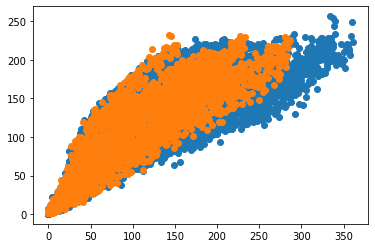

In [ ]:
#Correlation
#train
y_true = y_train
y_pred = xg_reg.predict(X_train)
plt.scatter(y_true,y_pred)
#Test
y_true = y_test
y_pred = xg_reg.predict(X_test)
plt.scatter(y_true,y_pred)

In [ ]:
time_series_fold(10,df,xg_reg)

Cross Validation 10 folds
----------Train-----------
RMSE Mean:  34.67778448085333 +-  0.7059432764794826
MAE Mean:  24.60696899578628 +-  0.4583458695610554
----------Test-----------
RMSE Mean:  38.93378582818015 +-  5.809761743201789
MAE Mean:  28.28843770119088 +-  3.1363226583340382


Train fit 


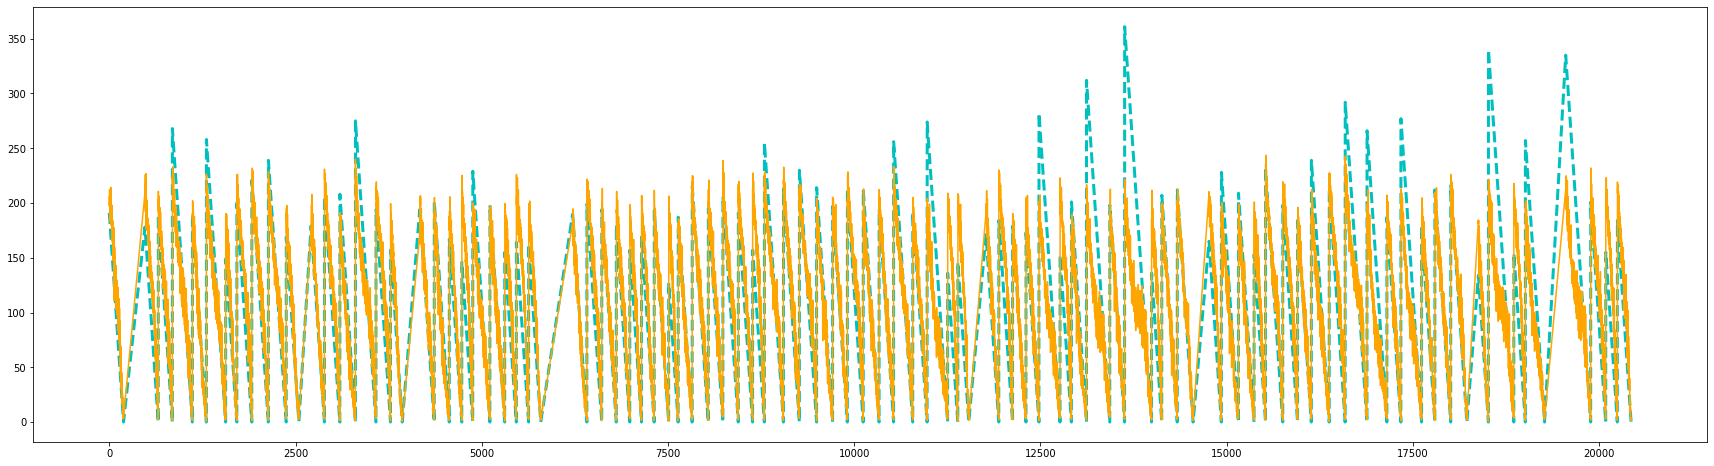

 
Test fit 
Asset 2
 


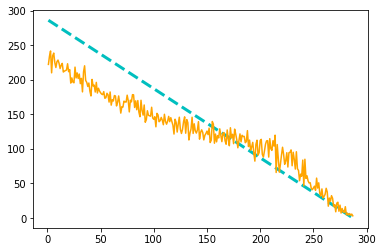

Asset 13
 


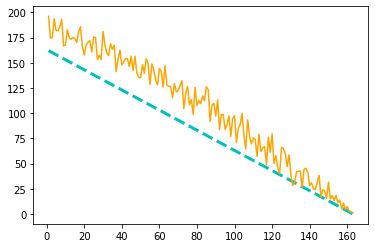

Asset 20
 


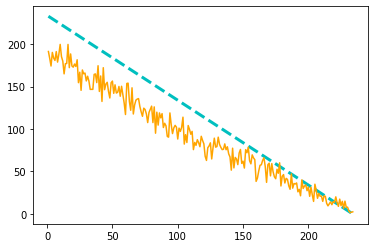

Asset 30
 


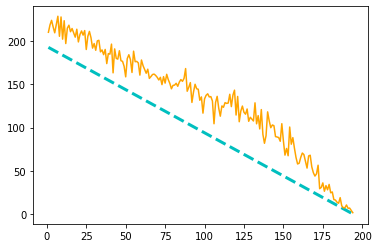

Asset 31
 


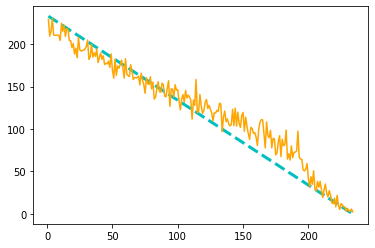

Asset 59
 


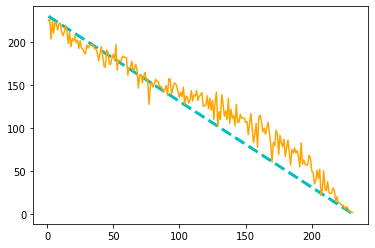

Asset 73
 


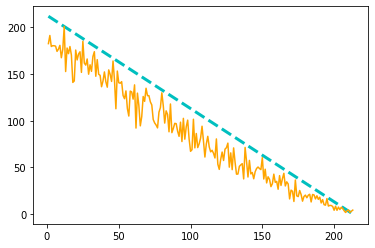

Asset 90
 


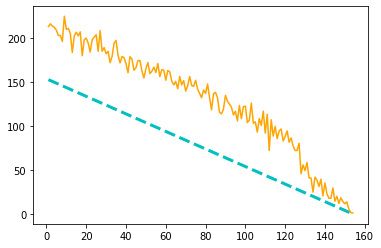

Asset 95
 


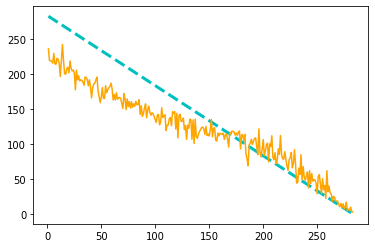

Asset 100
 


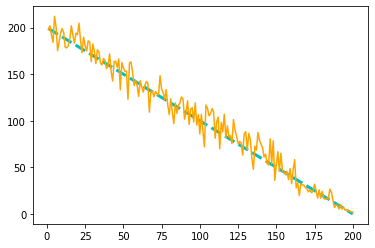

In [ ]:
evaluate_graphs(df,X_train, X_test, y_train, y_test, xg_reg,features)

    n_vals  k_vals  train_rmse  test_rmse
0       50    1.30   34.764900  33.825433
1       50    1.35   35.083034  34.204770
2       50    1.40   35.585775  34.694113
3       50    1.50   37.447659  36.816042
4      100    1.30   32.997746  33.160489
5      100    1.35   33.050633  33.351275
6      100    1.40   33.402399  33.265521
7      100    1.50   33.627113  33.231475
8      150    1.30   31.489176  33.393148
9      150    1.35   31.689663  33.504681
10     150    1.40   32.048581  33.521137
11     150    1.50   32.412303  33.397665
12     200    1.30   30.149349  33.617647
13     200    1.35   30.083357  33.807256
14     200    1.40   30.578526  33.635544
15     200    1.50   31.008922  33.698324


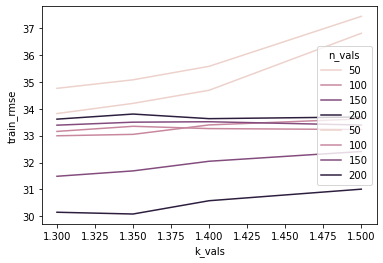

In [ ]:
#Grid Search
df_grid = pd.DataFrame()
k_list = ['reg:tweedie','reg:squarederror','reg:gamma']
k_list = [1.3,1.35,1.4,1.5]
n_list = [50,100,150,200]

for n in n_list:
  for k in k_list:
    #print(f"Running for n = {n} and k = {k}")

    xg_reg = xgb.XGBRegressor(objective='reg:tweedie' , tweedie_variance_power = k , learning_rate = 0.1, max_depth = 6, n_estimators = n, booster='gbtree')
    xg_reg.fit(X_train,y_train)
    metrics = evaluate(X_train, X_test, y_train, y_test, xg_reg, debug=False)

    df_grid = df_grid.append(pd.DataFrame({'n_vals':[n], 'k_vals':[k], 'train_rmse': [metrics['train_rmse']], 'test_rmse': [metrics['test_rmse']] }), ignore_index=True)
    #print(" ")

print(df_grid)

sns.lineplot(data=df_grid, x="k_vals", y="train_rmse", hue="n_vals")
#plt.show()
sns.lineplot(data=df_grid, x="k_vals", y="test_rmse", hue="n_vals")
#plt.show()

#reg:squarederror: regression with squared loss.
#reg:gamma: gamma regression with log-link. Output is a mean of gamma distribution. It might be useful, e.g., for modeling insurance claims severity, or for any outcome that might be gamma-distributed.
#reg:tweedie: Tweedie regression with log-link. It might be useful, e.g., for modeling total loss in insurance, or for any outcome that might be Tweedie-distributed.

# Random Forest

In [ ]:
X_train,y_train,X_test,y_test,features,scaler = preproc(df, deep=False)

Features after remove non-var features
runtime     68.726673
setting1     0.002187
setting2     0.000293
tag2         0.496193
tag3         6.098792
tag4         8.911816
tag6         0.001320
tag7         0.874283
tag8         0.070133
tag9        22.784489
tag11        0.263713
tag12        0.728020
tag13        0.070867
tag14       19.664056
tag15        0.037191
tag17        1.539102
tag20        0.179045
tag21        0.107339
dtype: float64
['runtime', 'tag2', 'tag3', 'tag4', 'tag7', 'tag8', 'tag11', 'tag12', 'tag13', 'tag15', 'tag17', 'tag20', 'tag21']
Features before selection:  25
Features after selection  13


In [ ]:
rfr = RandomForestRegressor(n_estimators = 50, criterion = 'mse', max_depth = 9, max_features='auto')

In [ ]:
rfr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=9, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
metrics = evaluate(X_train, X_test, y_train, y_test, rfr)

--------Train-------
r squared: 0.77
MAE: 23.425
MAPE: inf
RMSE: 32.688097
Correlation: 0.88
--------Test-------
r squared: 0.78
MAE: 25.586
MAPE: inf
RMSE: 32.509360
Correlation: 0.89


divide by zero encountered in true_divide
divide by zero encountered in true_divide


In [ ]:
simulate_scenarios(y, test_list, rfr.predict(X_test))

Size y_true:  2193
Size y_pred:  2193
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1983
           1       0.86      0.74      0.80       210

    accuracy                           0.96      2193
   macro avg       0.92      0.87      0.89      2193
weighted avg       0.96      0.96      0.96      2193

Confusion Matrix
[[1958   25]
 [  54  156]]


In [ ]:
time_series_fold(10,df,rfr)

Cross Validation 10 folds
----------Train-----------
RMSE Mean:  32.17128725249564 +-  0.987814874988183
MAE Mean:  23.284939352085757 +-  0.6887381097884744
----------Test-----------
RMSE Mean:  36.54919312584835 +-  8.553918790834198
MAE Mean:  27.005711325820666 +-  4.575508563808577


Train fit 


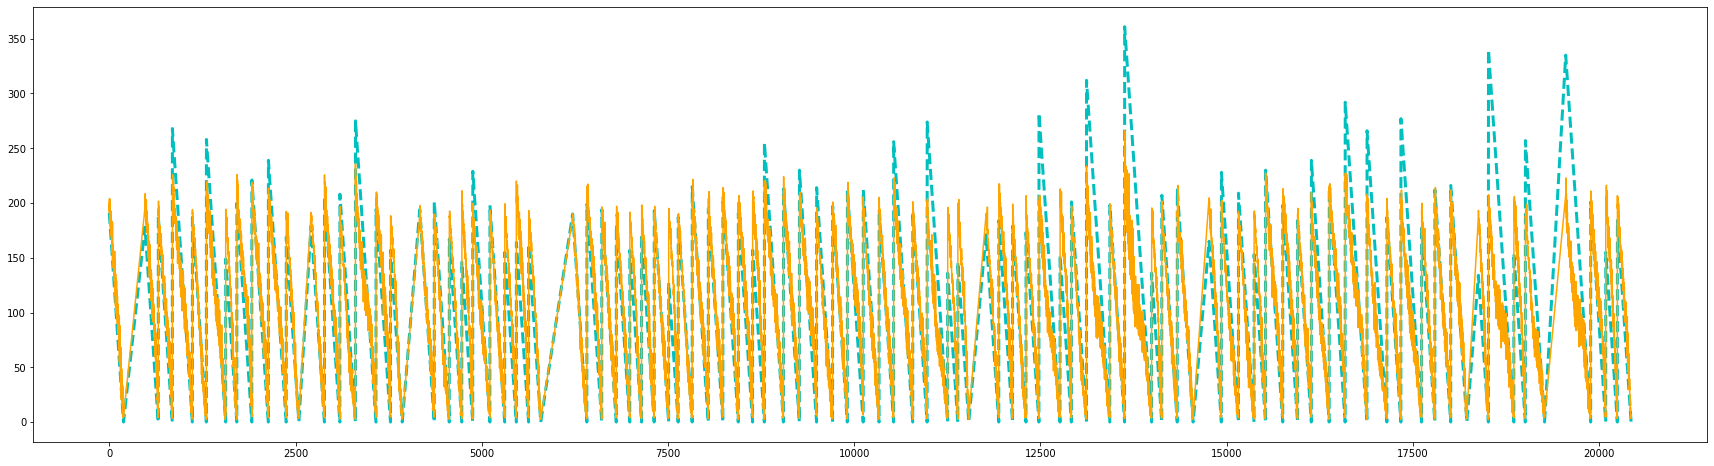

 
Test fit 
Asset 2
 


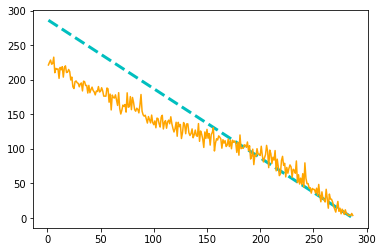

Asset 13
 


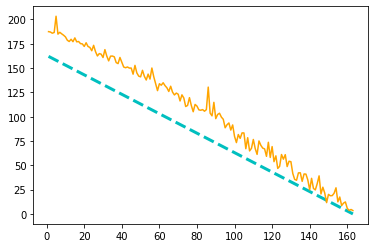

Asset 20
 


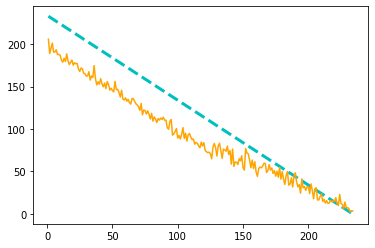

Asset 30
 


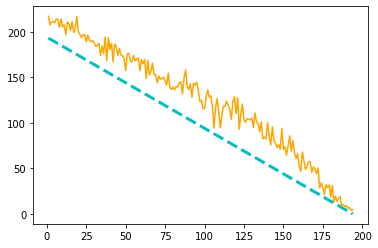

Asset 31
 


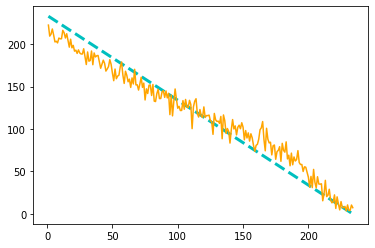

Asset 59
 


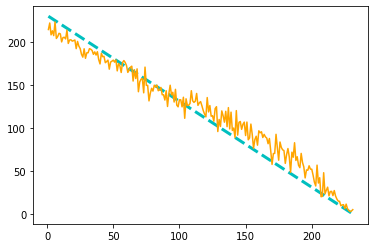

Asset 73
 


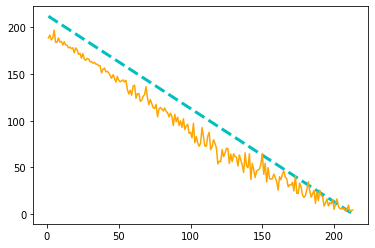

Asset 90
 


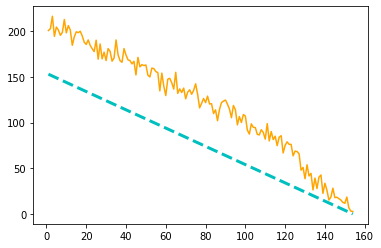

Asset 95
 


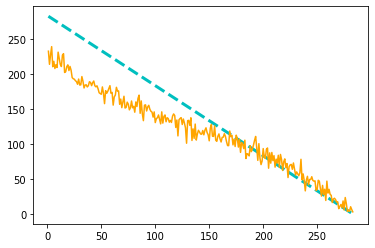

Asset 100
 


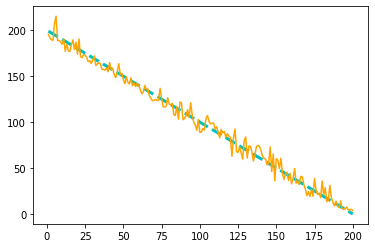

In [ ]:
evaluate_graphs(df,X_train, X_test, y_train, y_test, rfr, features)

    n_vals  k_vals  train_rmse  test_rmse
0        5       7   36.417775  32.891956
1        5       8   35.075752  33.195057
2        5       9   33.676571  33.055500
3        5      10   31.785567  34.206601
4       10       7   36.115732  32.644749
5       10       8   34.739247  32.532082
6       10       9   33.015644  32.941545
7       10      10   31.229761  33.240358
8       50       7   35.874967  32.310464
9       50       8   34.493022  32.473927
10      50       9   32.746806  32.530434
11      50      10   30.699335  32.674328


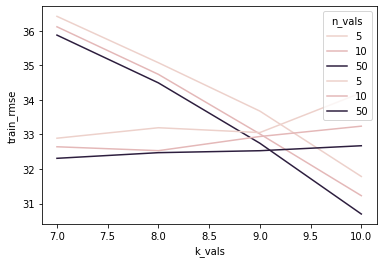

In [ ]:
#Grid Search
df_grid = pd.DataFrame()
k_list = [7,8,9,10]
n_list = [5,10,50]

for n in n_list:
  for k in k_list:
    #print(f"Running for n = {n} and k = {k}")

    rfr = RandomForestRegressor(n_estimators = n, criterion = 'mse', max_depth = k, max_features='auto')
    rfr.fit(X_train,y_train)
    metrics = evaluate(X_train, X_test, y_train, y_test, rfr, debug=False)

    df_grid = df_grid.append(pd.DataFrame({'n_vals':[n], 'k_vals':[k], 'train_rmse': [metrics['train_rmse']], 'test_rmse': [metrics['test_rmse']] }), ignore_index=True)
    #print(" ")

print(df_grid)

sns.lineplot(data=df_grid, x="k_vals", y="train_rmse", hue="n_vals")
sns.lineplot(data=df_grid, x="k_vals", y="test_rmse", hue="n_vals")


# SVM

In [ ]:
X_train,y_train,X_test,y_test,features, scaler = preproc(df, deep=False)

Features after remove non-var features
runtime     68.726673
setting1     0.002187
setting2     0.000293
tag2         0.496193
tag3         6.098792
tag4         8.911816
tag6         0.001320
tag7         0.874283
tag8         0.070133
tag9        22.784489
tag11        0.263713
tag12        0.728020
tag13        0.070867
tag14       19.664056
tag15        0.037191
tag17        1.539102
tag20        0.179045
tag21        0.107339
dtype: float64
['runtime', 'tag2', 'tag3', 'tag4', 'tag7', 'tag8', 'tag11', 'tag12', 'tag13', 'tag15', 'tag17', 'tag20', 'tag21']
Features before selection:  25
Features after selection  13


In [ ]:
#svr = svm.SVR().fit(X_train,y_train)
svr_rbf = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1).fit(X_train,y_train)
#svr_lin = svm.SVR(kernel='linear', C=100, gamma='auto').fit(X_train,y_train)
#svr_poly = svm.SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,coef0=1).fit(X_train,y_train)

In [ ]:
#metrics = evaluate(X_train, X_test, y_train, y_test, svr)

evaluate(X_train, X_test, y_train, y_test, svr_rbf)
#evaluate(X_train, X_test, y_train, y_test, svr_lin)
#evaluate(X_train, X_test, y_train, y_test, svr_poly)

--------Train-------
r squared: 0.73
MAE: 21.808
MAPE: inf
RMSE: 35.960937
Correlation: 0.86
--------Test-------
r squared: 0.77
MAE: 26.438
MAPE: inf
RMSE: 33.857220
Correlation: 0.89


{'test_mae': 26.43807772214395,
 'test_rmse': 33.857220045081114,
 'train_mae': 21.80811822885126,
 'train_rmse': 35.96093654633938}

In [ ]:
simulate_scenarios(y, test_list, svr_rbf.predict(X_test))

Size y_true:  2193
Size y_pred:  2193
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1983
           1       0.85      0.78      0.81       210

    accuracy                           0.97      2193
   macro avg       0.91      0.88      0.90      2193
weighted avg       0.96      0.97      0.97      2193

Confusion Matrix
[[1955   28]
 [  47  163]]


Train fit 


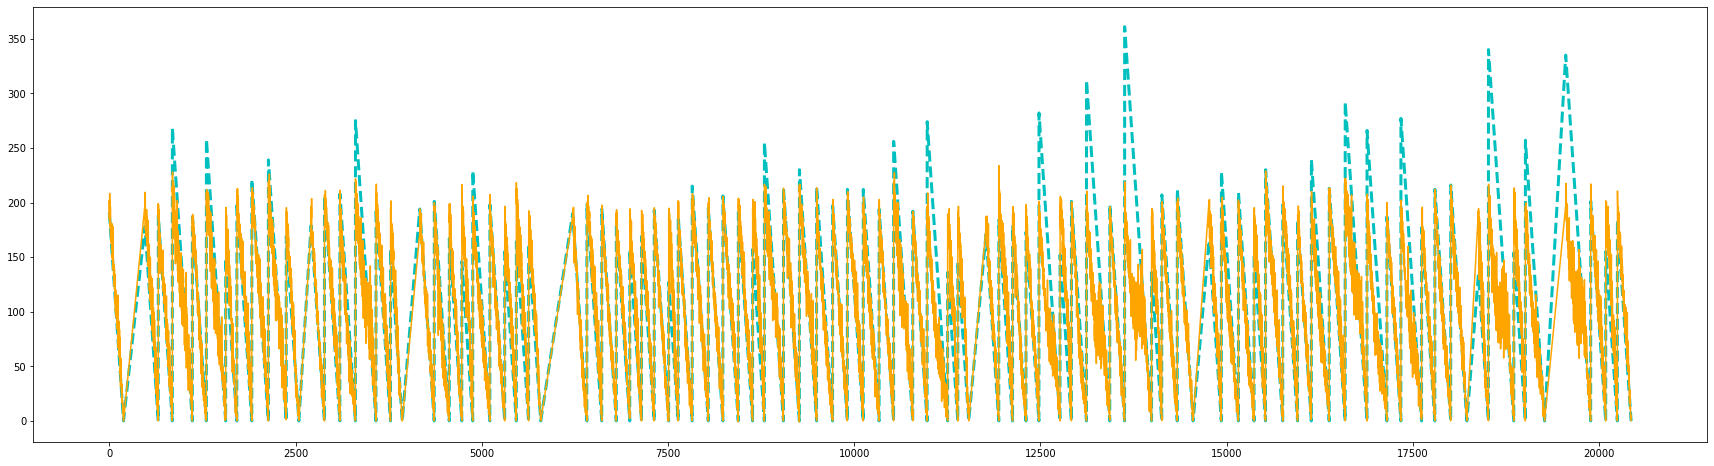

 
Test fit 
Asset 2
 


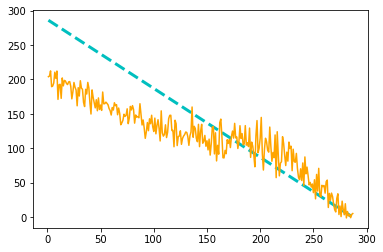

Asset 13
 


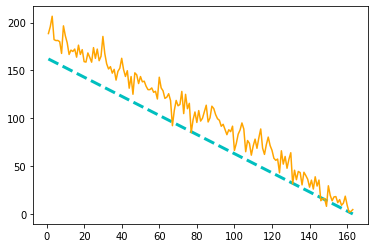

Asset 20
 


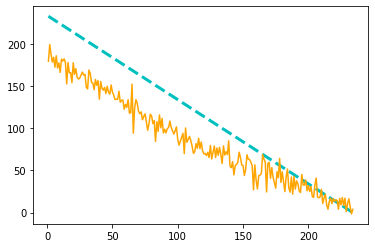

Asset 30
 


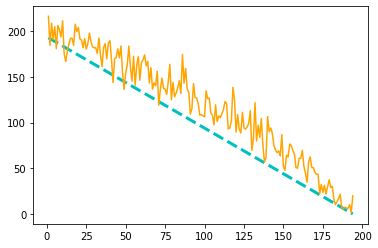

Asset 31
 


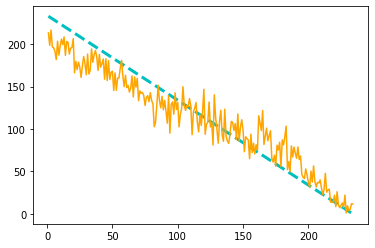

Asset 59
 


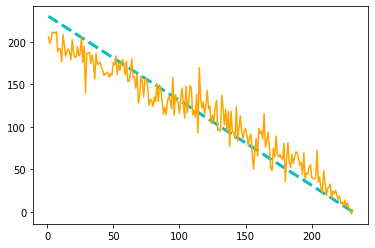

Asset 73
 


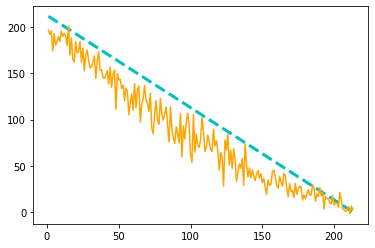

Asset 90
 


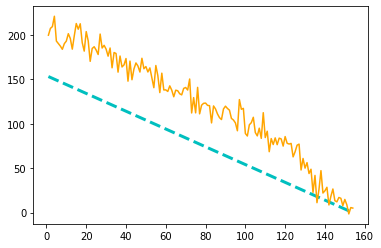

Asset 95
 


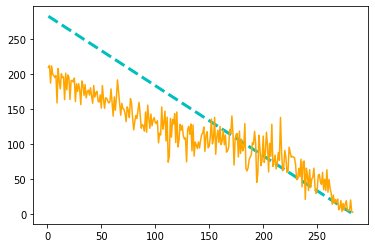

Asset 100
 


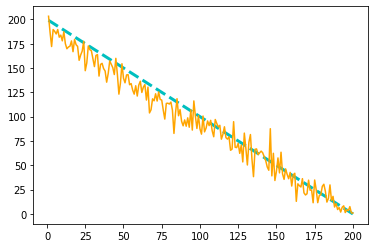

In [ ]:
evaluate_graphs(df,X_train, X_test, y_train, y_test, svr_rbf, features)

# Deep Learning

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor


In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[len(X_train.keys())]),
    #layers.Dense(16, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [ ]:
model = build_model()

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                224       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Mostra o progresso do treinamento imprimindo um único ponto para cada epoch completada
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

EPOCHS = 1000

history = model.fit(
  X_train, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop, PrintDot()])


....................................................................................

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss        mae          mse  ...    val_mae      val_mse  epoch
79  1119.387085  23.183222  1119.387085  ...  36.602707  2641.835693     79
80  1119.087280  23.198864  1119.087280  ...  36.538677  2614.781982     80
81  1118.125488  23.215906  1118.125488  ...  36.621025  2661.313232     81
82  1118.885132  23.196871  1118.885132  ...  36.602066  2658.020996     82
83  1118.317871  23.169987  1118.317871  ...  36.537445  2617.532471     83

[5 rows x 7 columns]

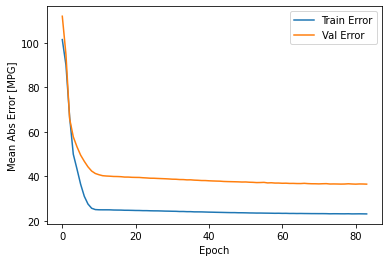

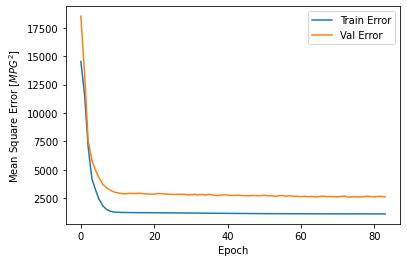

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [ ]:
metrics = evaluate(X_train, X_test, y_train, y_test, model, deep=True)

--------Train-------
r squared: 0.70
MAE: 25.910
MAPE: inf
RMSE: 37.643162
Correlation: 0.84
--------Test-------
r squared: 0.79
MAE: 25.401
MAPE: inf
RMSE: 31.917522
Correlation: 0.90


In [ ]:
time_series_fold(10,df,model, deep=True)

Cross Validation 10 folds
----------Train-----------
RMSE Mean:  37.0326743179559 +-  0.9527796797129475
MAE Mean:  72.12995331270363 +-  0.4364297526387167
----------Test-----------
RMSE Mean:  37.818277519030886 +-  8.559394970595628
MAE Mean:  72.54838681734222 +-  2.791061935253344


In [ ]:
simulate_scenarios(y, test_list, model.predict(X_test).flatten())

Train fit 


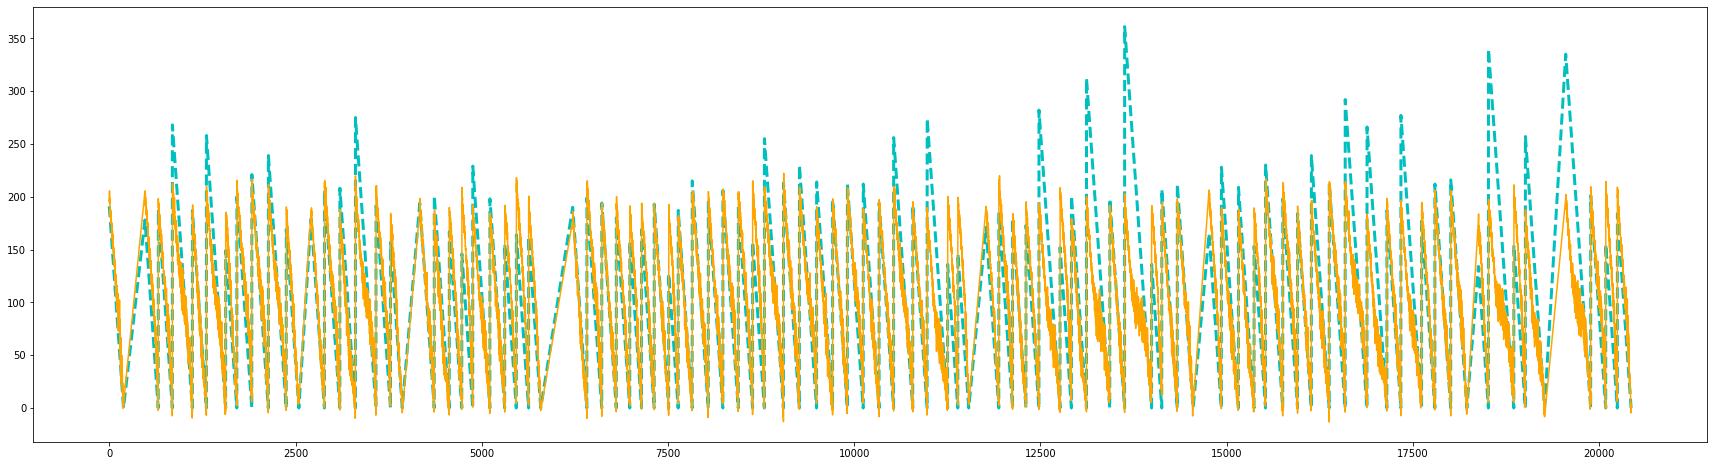

 
Test fit 
Asset 2
 


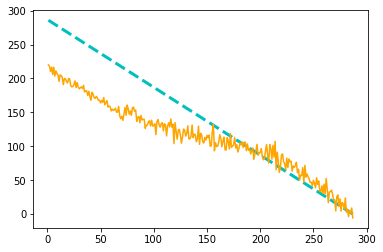

Asset 13
 


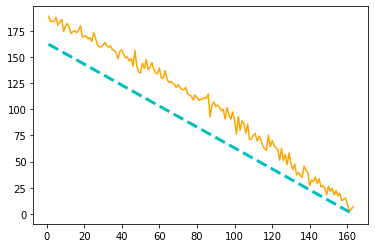

Asset 20
 


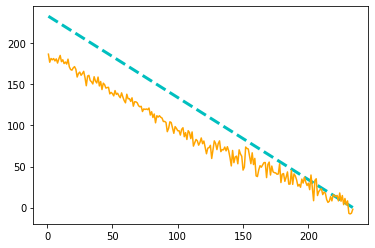

Asset 30
 


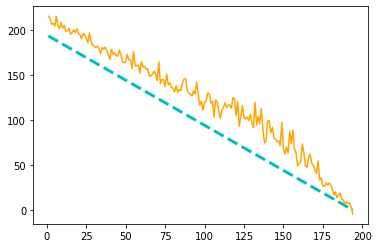

Asset 31
 


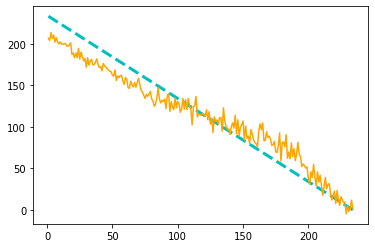

Asset 59
 


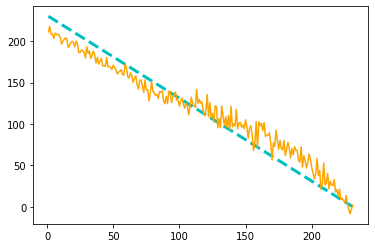

Asset 73
 


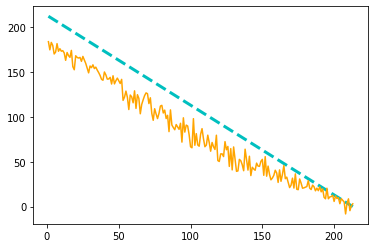

Asset 90
 


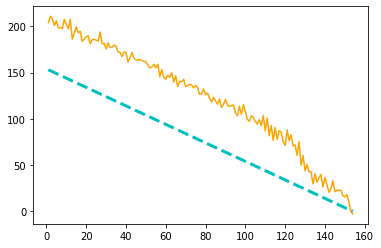

Asset 95
 


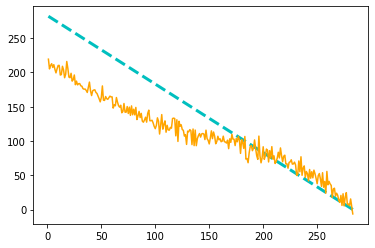

Asset 100
 


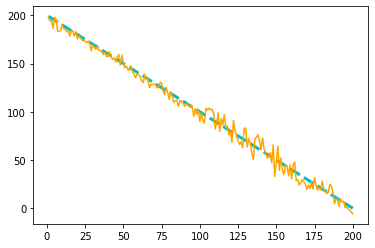

In [ ]:
evaluate_graphs(df,X_train, X_test, y_train, y_test, model, features, deep=True)

# Feature Importance


In [ ]:
explainer = shap.TreeExplainer(rfr)
shap_values = explainer.shap_values(X_train)

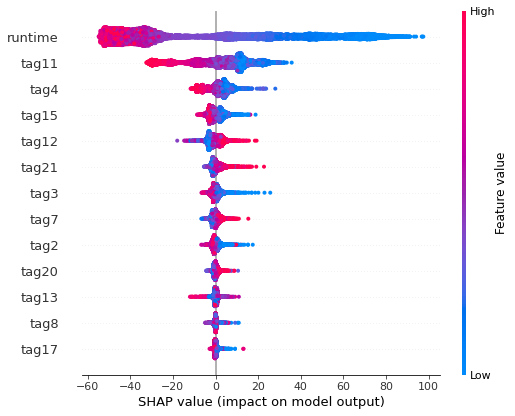

In [ ]:
shap.summary_plot(shap_values, X_train)

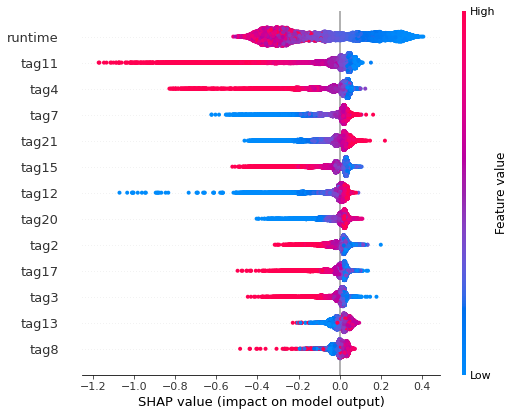

In [ ]:
explainer = shap.TreeExplainer(xg_reg)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

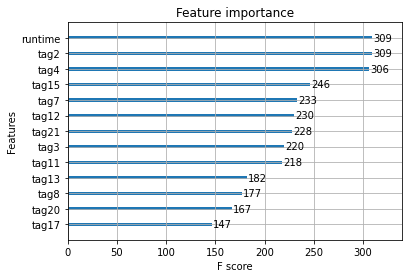

In [ ]:
xgb.plot_importance(xg_reg)

In [ ]:

shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

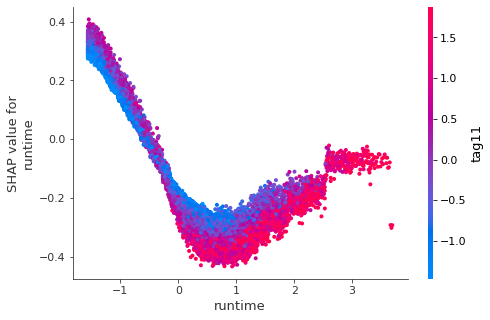

Exception ignored in: <bound method Booster.__del__ of <xgboost.core.Booster object at 0x7f3b1a298080>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/xgboost/core.py", line 957, in __del__
    if self.handle is not None:
AttributeError: 'Booster' object has no attribute 'handle'


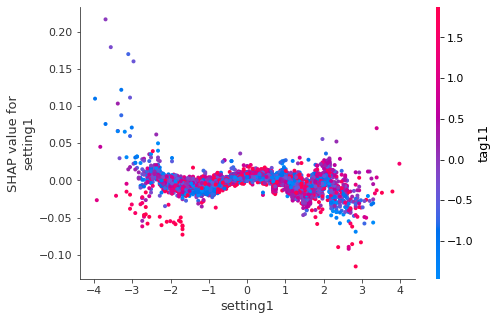

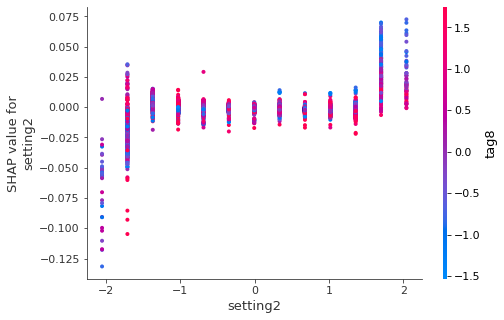

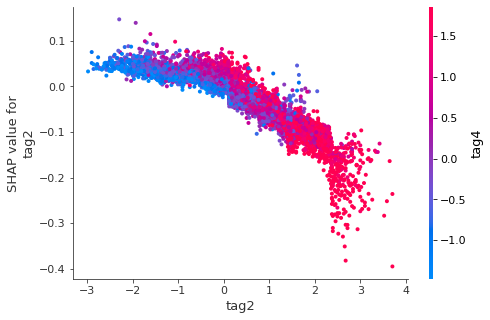

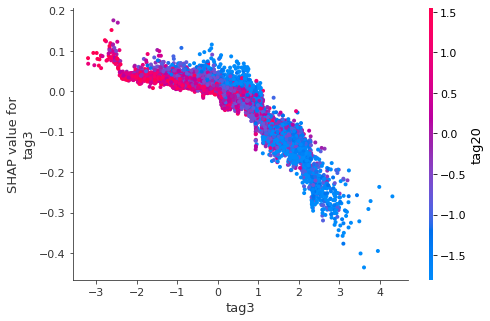

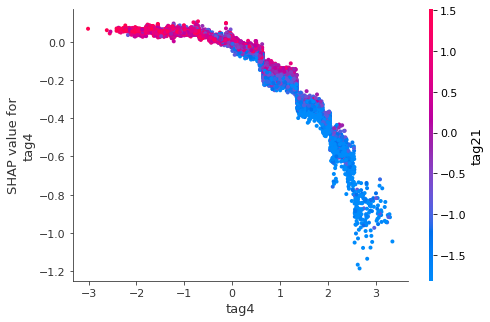

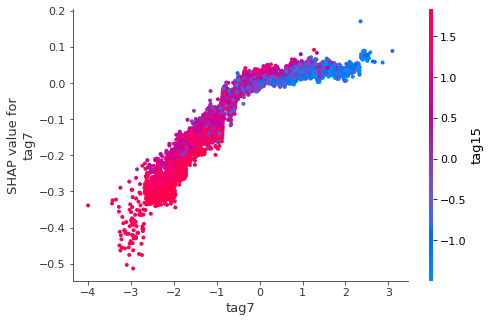

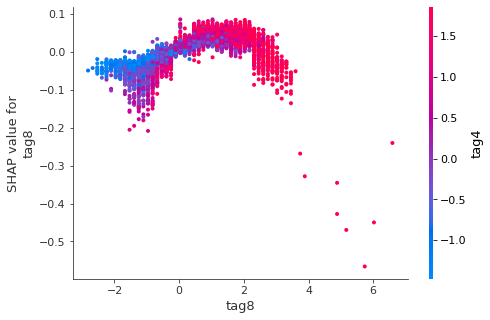

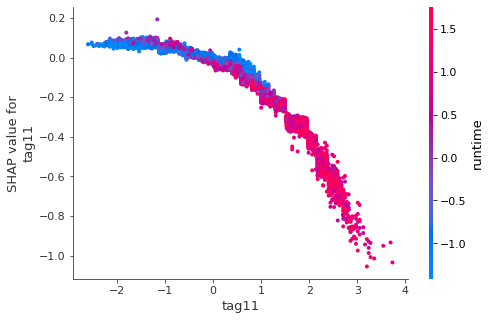

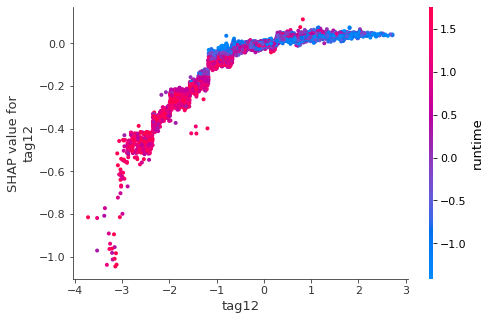

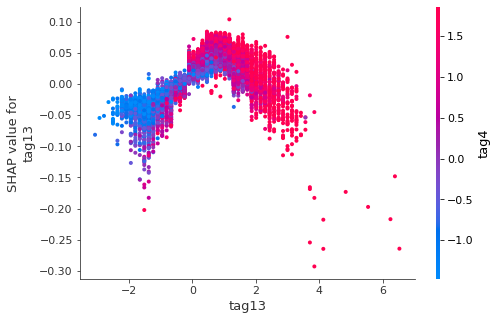

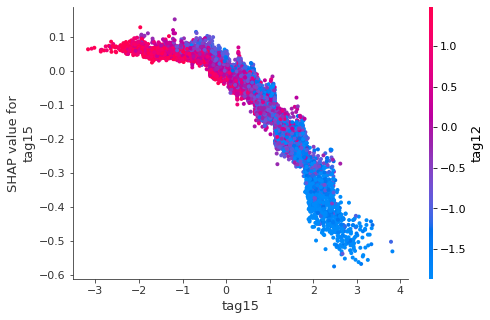

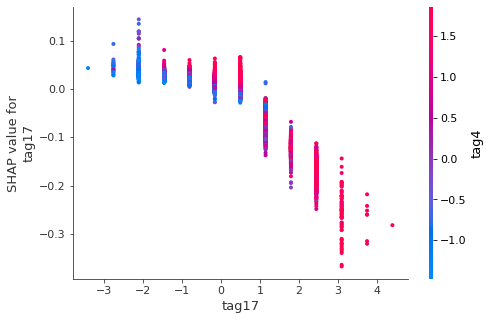

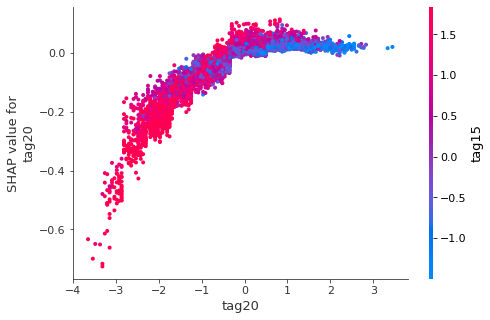

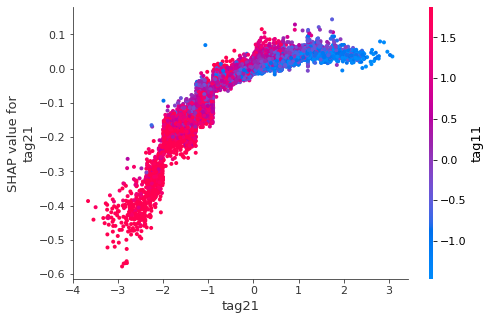

In [ ]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_train, display_features=X_train)

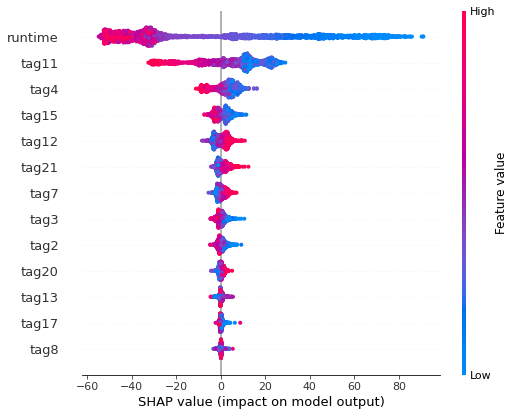

In [ ]:
explainer = shap.TreeExplainer(rfr)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

Notations
-------

* Lag features - use setpoint to lag
* Calculate time to run and plot results x time_to_run
* Use of Sklearn pipeline - adapt code



# Predict Validation Set


In [ ]:
df_test.describe()

asset_id       runtime  ...         tag20         tag21
count  13096.000000  13096.000000  ...  13096.000000  13096.000000
mean      51.543907     76.836515  ...     38.892502     23.335743
std       28.289423     53.057749  ...      0.141681      0.084120
min        1.000000      1.000000  ...     38.310000     22.935400
25%       28.000000     33.000000  ...     38.800000     23.281600
50%       52.000000     69.000000  ...     38.900000     23.339200
75%       76.000000    113.000000  ...     38.990000     23.393600
max      100.000000    303.000000  ...     39.410000     23.641900

[8 rows x 26 columns]

In [ ]:
features = list(X_test.columns)
print(features)

['runtime', 'tag2', 'tag3', 'tag4', 'tag7', 'tag8', 'tag11', 'tag12', 'tag13', 'tag15', 'tag17', 'tag20', 'tag21']


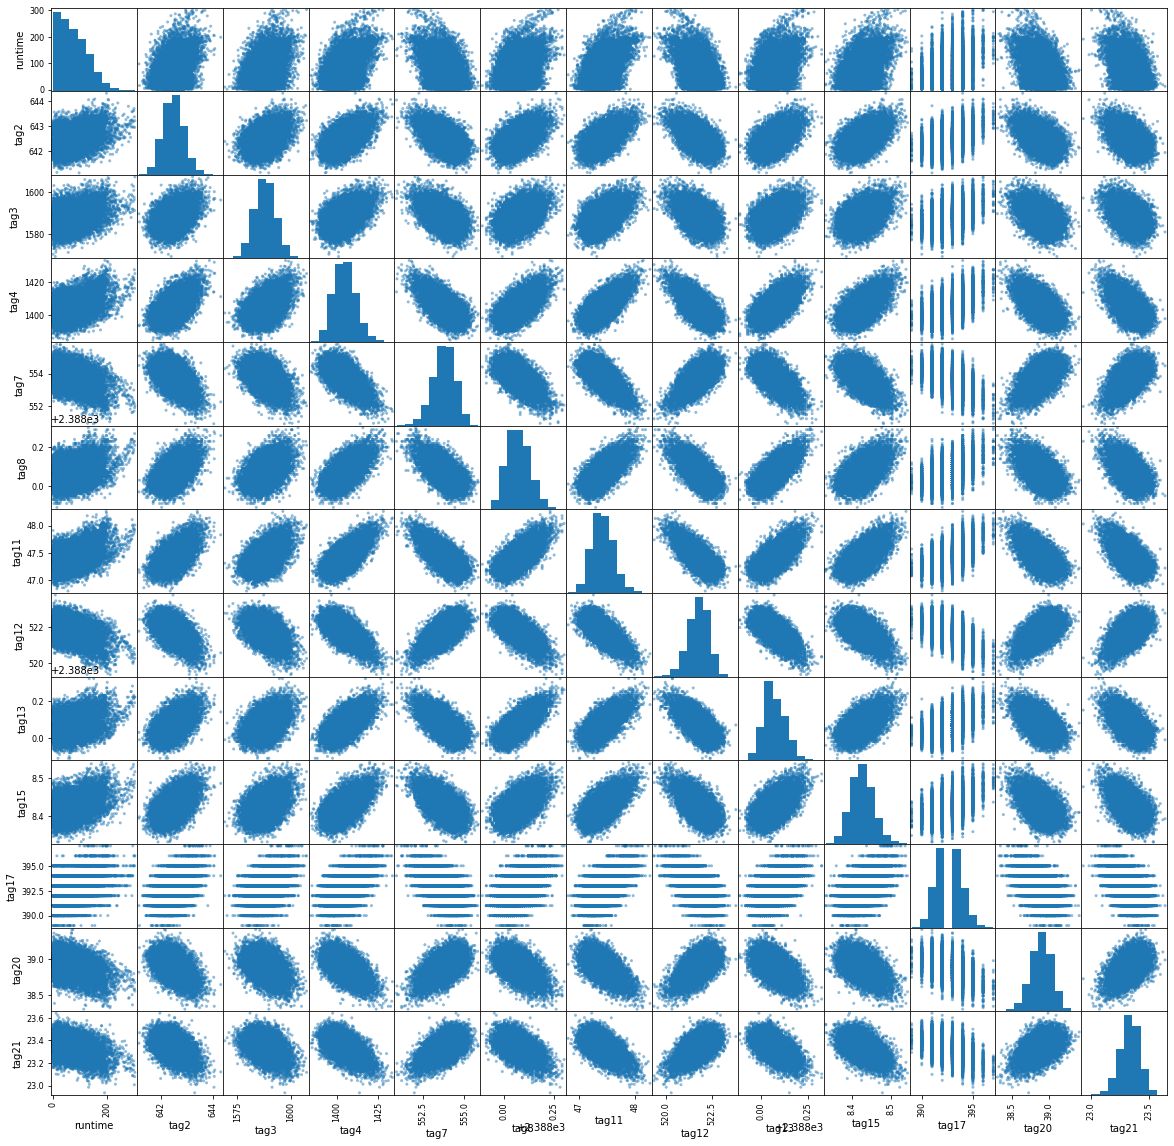

In [ ]:
pd.plotting.scatter_matrix(df_test[features], figsize=(20, 20))
plt.show()

In [ ]:
X_valid = df_test[features]
X_valid = scaler.transform(X_valid)

In [ ]:
y_pred = rfr.predict(X_valid)

In [ ]:
df_pred = pd.DataFrame({'predicted': y_pred})
df_pred

predicted
0      201.134085
1      209.449830
2      201.365913
3      195.513793
4      200.275683
...           ...
13091   42.234864
13092   49.263163
13093   62.361569
13094   48.413779
13095   31.077933

[13096 rows x 1 columns]

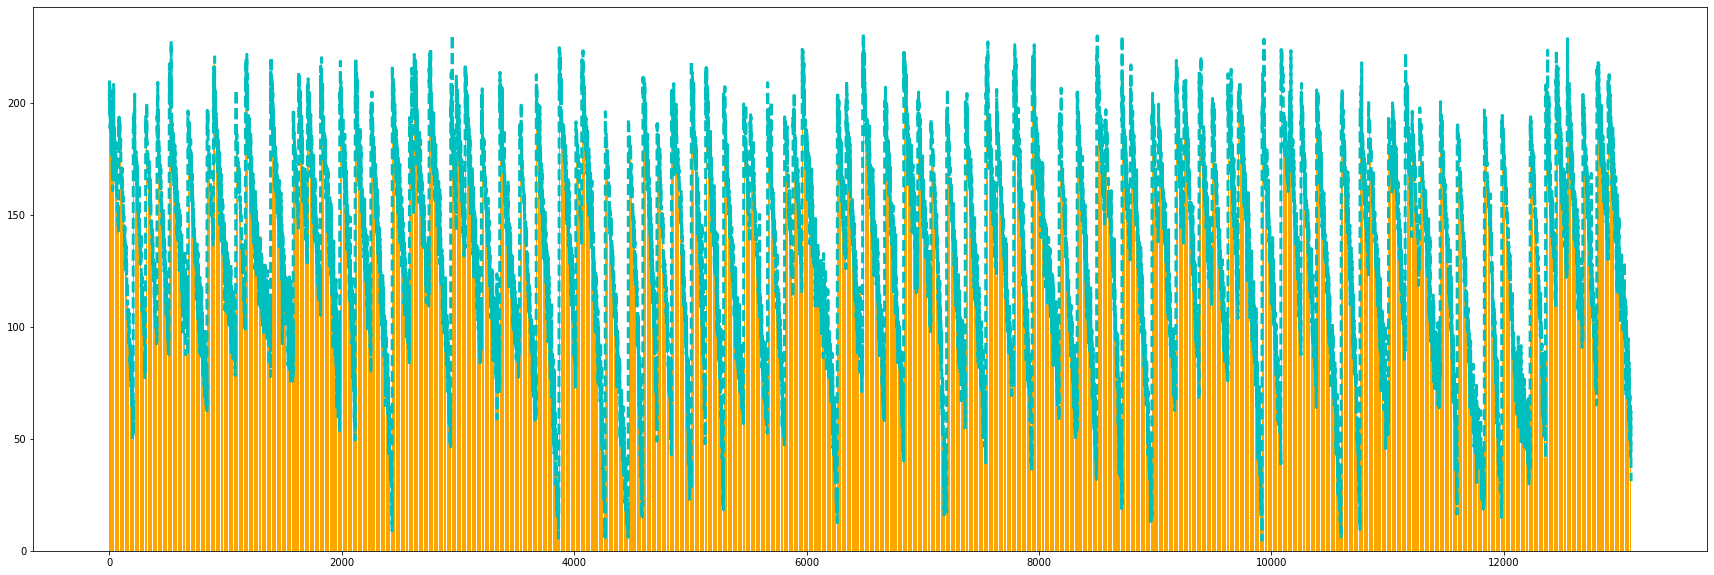

In [ ]:
plt.figure(figsize=(30, 10))
#plt.plot(df_test.index ,df_test.runtime, 'c--', linewidth=3)
plt.plot(df_test.index ,df_pred.predicted, 'c--', linewidth=3)
plt.bar(df_pred.index ,df_pred.predicted, color='orange')
plt.show()

In [ ]:
#save predictions
df_pred.to_csv('/gdrive/My Drive/regressao_octavio_santiago.csv', index = False)